# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://iie.fing.edu.uy/~jlezama/DLVIS2020/entregables.html) on the course website.*

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [23]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.336528
sanity check: 2.302585


**Inline Question 1**

- 1.1 Why do we expect our loss to be close to -log(0.1)? Explain briefly.
- 1.2 What are the minimum and maximum possible value for the Softmax loss? 

$\color{blue}{\textit Your Answer:}$ 

1: La expresión para la discrepancia es $-log(s)$ con s=probabilidad de las clases. Como hay 10 clases en nuestro dataset, la probabilidad es 1/10=0.1.

2: Como la discrepancia es $L=-\sum_{i=1}^nlog(s)+ \lambda W^TW$, para $\lambda=0$ y como "s" es una probabilidad el minimo es cero si s=1 y $\lambda=0$. No esta acotada por arriba.


In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.679611 analytic: 1.679611, relative error: 2.402868e-09
numerical: 1.933362 analytic: 1.933362, relative error: 2.294655e-09
numerical: -0.891891 analytic: -0.891892, relative error: 5.692857e-08
numerical: 3.403461 analytic: 3.403461, relative error: 1.642551e-08
numerical: 2.405056 analytic: 2.405056, relative error: 1.195105e-08
numerical: -0.262773 analytic: -0.262773, relative error: 2.552053e-09
numerical: 1.204526 analytic: 1.204526, relative error: 1.379204e-09
numerical: 0.778575 analytic: 0.778575, relative error: 7.187283e-09
numerical: -4.179224 analytic: -4.179224, relative error: 9.852101e-09
numerical: -0.301104 analytic: -0.301104, relative error: 1.206384e-07
numerical: -1.859856 analytic: -1.859856, relative error: 3.559530e-08
numerical: 0.098469 analytic: 0.098469, relative error: 2.853476e-07
numerical: -0.034095 analytic: -0.034095, relative error: 2.612257e-07
numerical: -2.113373 analytic: -2.113373, relative error: 3.086922e-08
numerical: 0.299491 

In [29]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# W e use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.336528e+00 computed in 0.084737s
vectorized loss: 2.336528e+00 computed in 0.002999s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [31]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1537.258967
iteration 100 / 1500: loss 207.095441
iteration 200 / 1500: loss 29.490943
iteration 300 / 1500: loss 5.796572
iteration 400 / 1500: loss 2.615515
iteration 500 / 1500: loss 2.214368
iteration 600 / 1500: loss 2.136669
iteration 700 / 1500: loss 2.158893
iteration 800 / 1500: loss 2.108022
iteration 900 / 1500: loss 2.156927
iteration 1000 / 1500: loss 2.165162
iteration 1100 / 1500: loss 2.148197
iteration 1200 / 1500: loss 2.111676
iteration 1300 / 1500: loss 2.117838
iteration 1400 / 1500: loss 2.110695
That took 6.341039s


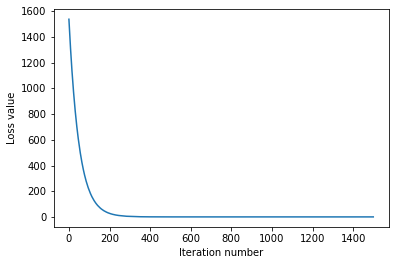

In [32]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [33]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print( 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.318245
validation accuracy: 0.325000


In [35]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save  the best trained softmax classifer in best_softmax.                    #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.0e4, 4e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# imitando la implementacion de sklearn, creo una grilla (matriz) de busqueda 
# permutando los hiperparametros utilizando lists comprehensions
grid_search = [[lr, rs] for lr in learning_rates for rs in regularization_strengths]

for learning_rate, regularization_strength in grid_search:
    softmax = Softmax()

    softmax.train(X_train, y_train, learning_rate=learning_rate, 
                      reg=regularization_strength, num_iters=1500, verbose=True)
    
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    
    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    results[(learning_rate, regularization_strength)] = \
                            (train_accuracy, val_accuracy)
    
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 623.066807
iteration 100 / 1500: loss 279.190307
iteration 200 / 1500: loss 126.048760
iteration 300 / 1500: loss 57.597823
iteration 400 / 1500: loss 26.883731
iteration 500 / 1500: loss 13.230844
iteration 600 / 1500: loss 7.058049
iteration 700 / 1500: loss 4.293707
iteration 800 / 1500: loss 3.058020
iteration 900 / 1500: loss 2.517822
iteration 1000 / 1500: loss 2.302306
iteration 1100 / 1500: loss 2.106710
iteration 1200 / 1500: loss 2.087322
iteration 1300 / 1500: loss 2.128839
iteration 1400 / 1500: loss 2.048018
iteration 0 / 1500: loss 1232.858069
iteration 100 / 1500: loss 248.192441
iteration 200 / 1500: loss 51.248378
iteration 300 / 1500: loss 11.954030
iteration 400 / 1500: loss 4.051047
iteration 500 / 1500: loss 2.548431
iteration 600 / 1500: loss 2.217373
iteration 700 / 1500: loss 2.148554
iteration 800 / 1500: loss 2.112109
iteration 900 / 1500: loss 2.152150
iteration 1000 / 1500: loss 2.111448
iteration 1100 / 1500: loss 2.084381
iteration

In [36]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.349000


**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution: 
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?
- How would it affect the training process? You may test this experimentally.


$\color{blue}{\textit Your Answer:}$

para $T=1$ se obtiene la misma discrepancia. Para $T<1$ el modelo tendrá mayor "confianza" en sus predicciones. Cuanto mayor sea la temperatura mas suave será el clasificador, esto quiere decir que tendrá menos confianza. Por ejemplo, si con $T=1$, el clasificador saca probabilidades (0.01 , 0.01 , 0.98), si aumentamos T se podría obtener algo de la forma (0.2,0.2,0.6) 

Al entrenar usando temperatura por ejemplo menor a 1 (modelo con mayor confianza en sus predicciones), se computa softmax utilizando valores mayores. El resultado es un clasificador mas propenso a errores. Se prueba (en otro notebook) y se observa que al entrenar con un valor menor a 1 para la temperatura, el término de loss disminuye mas rapidamente durante las iteraciones que con temperatura igual a 1. Se observa la tabla con los resultados en donde el accuracy en validacion se observa menor al de temperatura 1, coherente a lo expresado anteriormente: 


| T | Loss (última iter) | Training acc | Val acc |
| --- | --- | --- | --- |
| 0.1 | 1.91 | 0.29 | 0.3 |
| 1 | 2.11 | 0.31 | 0.32 |

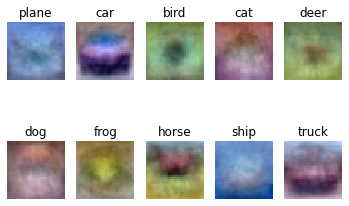

In [37]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])